In [1]:
%matplotlib inline
import sys
sys.path.append("..")

In [2]:
import random

import deeptrack as dt
from deeptrack import extras

import numpy as np
import skimage.color
import matplotlib.pyplot as plt


dt.backend.config.disable_gpu()

extras.datasets.load("ParticleTracking")

tracker_input_size = 128

# Can increase to get better validation accuracy at the cost of additional load time
max_frames_to_load = 2000

ParticleTracking already downloaded! Use force_overwrite=True to redownload the dataset.


In [3]:
import cv2

good_cap = cv2.VideoCapture("./datasets/ParticleTracking/ideal.avi")
bad_cap = cv2.VideoCapture("./datasets/ParticleTracking/bad.avi")

good_frames = []
bad_frames = []


normalization = (
    dt.DummyFeature()
    >> skimage.color.rgb2gray
    >> (lambda i:cv2.resize(i._value, (tracker_input_size, tracker_input_size)))
    >> dt.NormalizeMinMax()
)



idx = 0
while True:
    print(len(good_frames), "      ", end="\r")
    
    ret, frame = good_cap.read()
    if ret and len(good_frames) < max_frames_to_load:
        
        if len(good_frames) == 0:
            orig_size = frame.shape
        
        good_frames.append(normalization(frame))
    else:
        break
        
while True:
    print(len(bad_frames), "      ", end="\r")
    ret, frame = bad_cap.read()
    if ret and len(bad_frames) < max_frames_to_load:
        bad_frames.append(normalization(frame))
        
    else:
        break
        
print(f"Loaded {len(good_frames)} good frames and {len(bad_frames)} noisy frames")

Loaded 2000 good frames and 2000 noisy frames 


Low noise frames


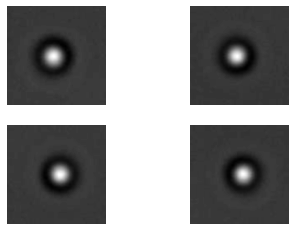

High noise frames


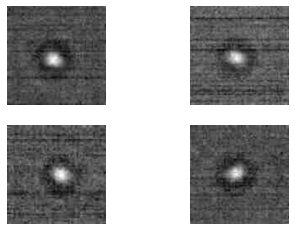

In [4]:

pipeline = dt.Value(
    use_good=True,
    use_bad=True,
    available_frames=lambda use_good, use_bad: (
        (good_frames if use_good else []) +
        (bad_frames if use_bad else [])
    ),
    value=lambda available_frames: random.choice(available_frames)
) >> dt.Affine(
    scale=lambda: np.random.choice([-1, 1], size=(2,))
)

print("Low noise frames")
for i in range(4):
    frame = pipeline.update().resolve(use_good=True, use_bad=False)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(frame, cmap="gray")
    plt.axis("off")
plt.show()
    
print("High noise frames")
for i in range(4):
    frame = pipeline.update().resolve(use_good=False, use_bad=True)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(frame, cmap="gray")
    plt.axis("off")
plt.show()


In [17]:
input_shape = (None, None, 1)

def total_loss(T, P):
    
    return dt.losses.adjacency_consistency(T, P) + dt.losses.squared_field_affine_consistency(T, P) * 20
    
import tensorflow as tf
model_trained_on_both = dt.models.autotrack.AutoMultiTracker(
    input_shape=input_shape, 
    loss=total_loss,
    metrics=[dt.losses.adjacency_consistency, dt.losses.squared_field_affine_consistency],
    optimizer=tf.keras.optimizers.Adam(amsgrad=True, lr=0.004)
)
model_trained_on_low_noise = dt.models.autotrack.AutoMultiTracker(input_shape=input_shape, 
    loss=total_loss,
    metrics=[dt.losses.adjacency_consistency, dt.losses.squared_field_affine_consistency]
                                                                 )
model_trained_on_high_noise = dt.models.autotrack.AutoMultiTracker(input_shape=input_shape, 
    loss=total_loss,
    metrics=[dt.losses.adjacency_consistency, dt.losses.squared_field_affine_consistency]
                                                                  )

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [16]:
h_both = model_trained_on_both.fit(pipeline, batch_size=8, epochs=10)
# h_low = model_trained_on_low_noise.fit(dt.Bind(pipeline, use_bad=False), batch_size=8, epochs=10)
# h_high = model_trained_on_high_noise.fit(dt.Bind(pipeline, use_good=False), batch_size=8, epochs=10)

Generating 977 / 800 samples before starting training
Epoch 1/10
168/977 [====>.........................] - ETA: 18s - loss: 32.8625 - adjacency_consistency: 16.0000 - field_affine_consistency: 0.8431

KeyboardInterrupt: 

In [ ]:
from deeptrack.extras.radialcenter import radialcenter


print("Predicting model_trained_on_both...")
pred_both_good = model_trained_on_both.predict(np.array(good_frames)).mean(axis=(1, 2))
pred_both_bad = model_trained_on_both.predict(np.array(bad_frames)).mean(axis=(1, 2)) 

print("Predicting model_trained_on_low_noise...")
pred_low_good = model_trained_on_low_noise.predict(np.array(good_frames)).mean(axis=(1, 2)) 
pred_low_bad = model_trained_on_low_noise.predict(np.array(bad_frames)).mean(axis=(1, 2)) 

print("Predicting model_trained_on_high_noise...")
pred_high_good = model_trained_on_high_noise.predict(np.array(good_frames)).mean(axis=(1, 2))  
pred_high_bad = model_trained_on_high_noise.predict(np.array(bad_frames)).mean(axis=(1, 2)) 
print("Predicting using radialcenter...")

pred_radialcenter_good = np.array([radialcenter(f)[::-1] for f in good_frames])
pred_radialcenter_bad = np.array([radialcenter(f)[::-1] for f in bad_frames])

In [ ]:

plt.imshow(pred_both_good[0, ..., 0])
plt.colorbar()

In [ ]:
pred_both_good = model_trained_on_both.predict(np.array(good_frames[:4]))

Y, X = np.meshgrid(
    np.arange(pred_both_good.shape[1]) - pred_both_good.shape[1]/2, 
    np.arange(pred_both_good.shape[2]) - pred_both_good.shape[2]/2
) 

for pred, _ in zip(pred_both_good, range(4)):
    
    pred = pred[..., :2] + np.stack((X, Y), axis=-1)
    
    plt.subplot(1, 2, 1)
    plt.imshow(pred[3:-3, 3:-3, 1])
    plt.colorbar()
    
    plt.show()

In [ ]:
# a = np.array([1, 2]).mean()

In [ ]:
augmentation=dt.Affine(
     translate=lambda: (np.random.rand() - 0.5) * 6,
     scale=lambda: np.random.choice([-1, 1], size=(2,))
 )

In [ ]:
def get_msd(x, max_dt=4):

    output_x = []
    output_y = []
    output_r = []
    for delt in range(max_dt):
        delta = x[1 + delt :] - x[: -(1 + delt)]
        squared_displacement = np.square(delta)
        
        dx = squared_displacement[:, 0]
        dy = squared_displacement[:, 1]
        dr = squared_displacement.sum(axis=-1) / 2
        
        output_x.append(      
            np.mean(dx),
        )
        output_y.append(
            np.mean(dy),
        )
        output_r.append(
            np.mean(dr)
        )
        
    return np.array(output_x), np.array(output_y), np.array(output_r)


def get_tracking_error(msd):
    
    k = msd[1] - msd[0]
    y0 = msd[0] - k
    return y0
    
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
msd_r_both = get_msd(pred_both_good, 100)[0]
msd_r_low = get_msd(pred_low_good, 100)[0]
msd_r_high = get_msd(pred_high_good, 100)[0]

msd_r_radial = get_msd(pred_radialcenter_good, 100)[0]

tracking_error_both = get_tracking_error(msd_r_both)
tracking_error_low = get_tracking_error(msd_r_low)
tracking_error_high = get_tracking_error(msd_r_high)
tracking_error_radial = get_tracking_error(msd_r_radial)

plt.plot(msd_r_both - tracking_error_both)
plt.plot(msd_r_low - tracking_error_low)
plt.plot(msd_r_high - tracking_error_high)
plt.plot(msd_r_radial - tracking_error_radial)

plt.legend([
    f"Both, pxerr={tracking_error_both:.3f}", 
    f"Low, pxerr={tracking_error_low:.3f}", 
    f"High, pxerr={tracking_error_high:.3f}",
    f"Radialcenter, pxerr={tracking_error_radial:.3f}"
])

plt.subplot(1, 2, 2)
msd_r_both = get_msd(pred_both_bad, 100)[0]
msd_r_low = get_msd(pred_low_bad, 100)[0]
msd_r_high = get_msd(pred_high_bad, 100)[0]
msd_r_radial = get_msd(pred_radialcenter_bad, 100)[0]

tracking_error_both = get_tracking_error(msd_r_both)
tracking_error_low = get_tracking_error(msd_r_low)
tracking_error_high = get_tracking_error(msd_r_high)
tracking_error_radial = get_tracking_error(msd_r_radial)


plt.plot(msd_r_both - tracking_error_both)
plt.plot(msd_r_low - tracking_error_low)
plt.plot(msd_r_high - tracking_error_high)
plt.plot(msd_r_radial - tracking_error_radial)

plt.legend([
    f"Both, pxerr={tracking_error_both:.3f}", 
    f"Low, pxerr={tracking_error_low:.3f}", 
    f"High, pxerr={tracking_error_high:.3f}",
    f"Radialcenter, pxerr={tracking_error_radial:.3f}"
])

plt.show()

In [ ]:
import IPython.display as display

p = pred_both_good[:, :2] - np.mean(pred_both_good, axis=0)[:2] + np.mean(pred_radialcenter_good, axis=0)
for idx, frame in enumerate(good_frames):
    display.clear_output(wait=True)
    plt.imshow(frame)
    plt.scatter(
        p[idx, 1], 
        p[idx, 0], 
        marker='x'
    )
    plt.scatter(
        pred_radialcenter_good[idx, 1], 
        pred_radialcenter_good[idx, 0], 
        marker='o'
    )
    plt.show()

In [ ]:
model_trained_on_both.save("./network")

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("./network")

In [ ]:
plt.imshow(good_frames[0], cmap="gray")
plt.axis("off")
plt.savefig("./particle.png")